
# Set up the notebook

In [1]:

%pprint

Pretty printing has been turned OFF


In [2]:

import sys

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

from choropleth_utils import ChoroplethUtilities
from stats_scraping_utils import StatsScrapingUtilities
from storage import Storage
import pandas as pd
import re
import os
import numpy as np

s = Storage()
ssu = StatsScrapingUtilities(s=s)

In [25]:

import matplotlib.pyplot as plt

# Use the following only if you are on a high definition device
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

from scipy.optimize import curve_fit
import numpy as np
import math
%matplotlib inline

def func(x, a, b):

    return a*x + b


## Prepare for and Create Choropleth

In [25]:

birth_rate_df = ssu.get_page_tables('https://www.macrotrends.net/countries/ranking/birth-rate')[0].melt(
    id_vars=['Country Name'],
    value_vars=['2020', '2019', '2018', '2017', '2016'],
    var_name='country_year',
    value_name='birth_rate'
).sort_values(['Country Name', 'country_year'], ascending=[True, True])
birth_rate_funcs_dict = {}
for country_name in birth_rate_df['Country Name'].unique():
    mask_series = (birth_rate_df['Country Name'] == country_name)
    df = birth_rate_df[mask_series]
    popt, pcov = curve_fit(func, [int(country_year) for country_year in df.country_year],
                           [float(birth_rate) for birth_rate in df.birth_rate])
    def get_birth_rate(country_year):
        '''Get the birth rate given a year'''

        return round(popt[0]*country_year + popt[1], 2)
    birth_rate_df.loc[mask_series, 'a'] = popt[0]
    birth_rate_df.loc[mask_series, 'b'] = popt[1]
    birth_rate_funcs_dict[country_name] = get_birth_rate

[(0, (209, 6))]


In [29]:

death_rate_df = ssu.get_page_tables('https://www.macrotrends.net/countries/ranking/death-rate')[0].melt(
    id_vars=['Country Name'],
    value_vars=['2020', '2019', '2018', '2017', '2016'],
    var_name='country_year',
    value_name='death_rate'
).sort_values(['Country Name', 'country_year'], ascending=[True, True])
death_rate_funcs_dict = {}
for country_name in death_rate_df['Country Name'].unique():
    mask_series = (death_rate_df['Country Name'] == country_name)
    df = death_rate_df[mask_series]
    popt, pcov = curve_fit(func, [int(country_year) for country_year in df.country_year],
                           [float(death_rate) for death_rate in df.death_rate])
    def get_death_rate(country_year):
        '''Get the death rate given a year'''

        return round(popt[0]*country_year + popt[1], 2)
    death_rate_df.loc[mask_series, 'a'] = popt[0]
    death_rate_df.loc[mask_series, 'b'] = popt[1]
    death_rate_funcs_dict[country_name] = get_death_rate

[(0, (208, 6))]


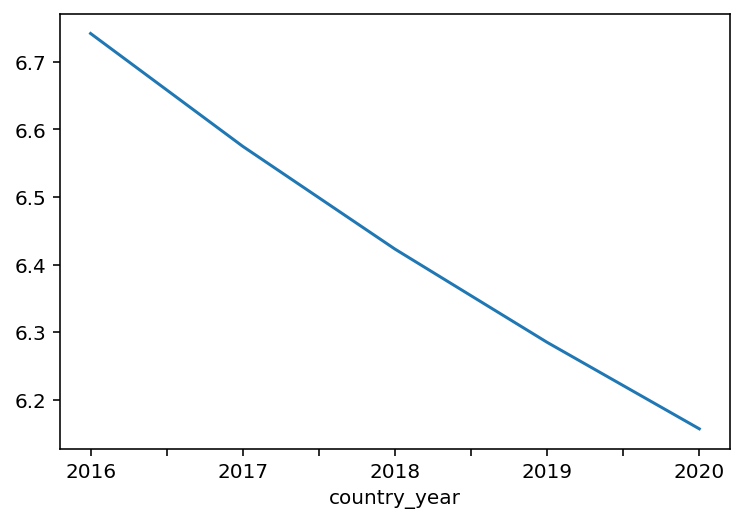

In [34]:

country_name = 'Afghanistan'
mask_series = (death_rate_df['Country Name'] == country_name)
death_rate_df[mask_series].set_index('country_year').death_rate.plot();

In [50]:

on_list = ['Country Name', 'country_year']
subset_list = ['Country Name', 'a_birth', 'b_birth', 'a_death', 'b_death']
peak_year_df = birth_rate_df.merge(death_rate_df, on=on_list, suffixes=['_birth', '_death']).drop_duplicates(subset=subset_list, ignore_index=True)
peak_year_df['peak_year'] = np.nan
for row_index, row_series in peak_year_df.iterrows():
    a_birth = row_series.a_birth
    b_birth = row_series.b_birth
    a_death = row_series.a_death
    b_death = row_series.b_death
    peak_year = (b_death-b_birth)/(a_birth-a_death)
    peak_year_df.loc[row_index, 'peak_year'] = peak_year

In [63]:

peak_year_df.columns = ['country_name', 'country_year', 'birth_rate', 'a_birth', 'b_birth', 'death_rate', 'a_death', 'b_death', 'peak_year']
columns_list = ['country_name', 'birth_rate', 'a_birth', 'b_birth', 'death_rate', 'a_death', 'b_death', 'peak_year']
peak_year_df = peak_year_df[columns_list]
peak_year_df.sort_values('peak_year')

,country_name,birth_rate,a_birth,b_birth,death_rate,a_death,b_death,peak_year
126,Mozambique,38.236,-0.3566,757.140002,9.463,-3.780000e-01,771.4300,667.756955
169,Somalia,42.096,-0.1714,387.637006,11.289,-1.969000e-01,408.2194,807.152793
36,Central African Republic,36.029,-0.2870,614.567200,13.119,-3.491000e-01,716.8388,1646.885668
62,Faroe Islands,13.600,-0.1300,275.580000,7.700,-2.300000e-01,472.0000,1964.200000
199,Uzbekistan,22.800,0.5800,-1147.020000,4.900,-2.099210e-12,4.8600,1986.000000
...,...,...,...,...,...,...,...,...
134,Niger,47.017,-0.4511,956.417000,8.820,-2.502000e-01,513.1970,2206.172225
111,Madagascar,33.138,-0.2475,532.104000,6.324,-1.262000e-01,260.7348,2237.173949
60,Eswatini,27.176,-0.4444,923.113600,10.462,-3.954000e-01,807.4406,2360.673469
186,Timor-Leste,29.399,-0.0921,215.174400,6.109,-5.390000e-02,114.7682,2628.434555


In [57]:

cu = ChoroplethUtilities(s=s)
[fn for fn in dir(cu) if fn.endswith('_df')]

['all_countries_df', 'one_country_df']

In [68]:

%run ../load_magic/lists.py

mask_series = cu.all_countries_df.country_name.isin(peak_year_df.country_name)
left_list = list(set(peak_year_df.country_name) - set(cu.all_countries_df[mask_series].country_name))
name_similarities_df = check_for_typos(left_list, cu.all_countries_df[mask_series].country_name.unique().tolist())
name_similarities_df.sort_values('max_similarity', ascending=False)

,left_item,right_item,max_similarity
20,Channel Islands,Cayman Islands,0.758621
13,Macao,Monaco,0.727273
16,Bosnia,Botswana,0.714286
7,Slovak Republic,Dominican Republic,0.666667
6,Micronesia,Indonesia,0.631579
8,Syrian Arab Republic,Dominican Republic,0.631579
2,Czech Republic,Central African Republic,0.631579
22,Curacao,Croatia,0.571429
17,Democratic Republic Of Congo,Dominican Republic,0.565217
21,Cabo Verde,Cambodia,0.555556


In [70]:

for row_index, row_series in peak_year_df.iterrows():
    country_name = row_series.country_name
    peak_year = row_series.peak_year
    mask_series = (cu.all_countries_df.country_name == country_name)
    cu.all_countries_df.loc[mask_series, 'peak_year'] = peak_year
cu.s.store_objects(all_countries_df=cu.all_countries_df)

Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\StatsByCountry\saves\pkl\all_countries_df.pkl


In [81]:

mask_series = cu.all_countries_df.country_name.isnull()
df = cu.all_countries_df[~mask_series]
df['country_code'] = df.iso_3166_2.map(lambda x: str(x).split(':')[-1])
one_country_df = df.set_index('country_name', drop=True).rename(columns={'country_code': 'district_abbreviation'})
one_country_df['label_line_d'] = np.nan
df = df.set_index('country_code', drop=True)
cu = ChoroplethUtilities(iso_3166_2_code='af', one_country_df=one_country_df, all_countries_df=df)
cu.create_label_line_file()
string_column_name = 'peak_year'
svg_file_path = cu.create_country_labeled_map(string_column_name=string_column_name)
print(os.path.abspath(svg_file_path))

Exception: one_country_df needs to have the outline_d column

In [79]:

cu.all_countries_df

,country_name,year_code_established,cc_tld,iso_3166_2,code_notes,wikipedia_url,wikipedia_title,intra_country_borders_d,svg_height,svg_width,inkscape_cx,inkscape_cy,inkscape_zoom,font_size,legend_transform,pwrindx_rank,short_form_name,pwrindx_score,peak_year
country_code,,,,,,,,,,,,,,,,,,,
AD,Andorra,1974,.ad,ISO 3166-2:AD,NaN,https://en.wikipedia.org/wiki/Andorra,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.525424
AE,UAE,1974,.ae,ISO 3166-2:AE,NaN,https://en.wikipedia.org/wiki/United_Arab_Emir...,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.0,UAE,0.5859,2071.842137
AF,Afghanistan,1974,.af,ISO 3166-2:AF,NaN,https://en.wikipedia.org/wiki/Afghanistan,Afghanistan,"m 920.059,219.437 c 0.126,1.93 0.2,3.878 -0.03...",1331.225,1807.436,903.54352,665.6215,0.665878,16.0,"matrix(2,0,0,2,-50,-90)",118.0,AFG,3.3736,2064.548439
AG,Antigua & Barbuda,1974,.ag,ISO 3166-2:AG,NaN,https://en.wikipedia.org/wiki/Antigua_and_Barbuda,Antigua and Barbuda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AI,Anguilla,1985,.ai,ISO 3166-2:AI,AI previously represented French Afars and Issas,https://en.wikipedia.org/wiki/Anguilla,Anguilla,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YE,Yemen,1974,.ye,ISO 3166-2:YE,"Previous ISO country name: Yemen, Republic of ...",https://en.wikipedia.org/wiki/Yemen,Yemen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,YEM,1.4754,2060.020254
YT,Mayotte,1993,.yt,ISO 3166-2:YT,NaN,https://en.wikipedia.org/wiki/Mayotte,Mayotte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZA,South Africa,1974,.za,ISO 3166-2:ZA,Code taken from name in Dutch: Zuid-Afrika,https://en.wikipedia.org/wiki/South_Africa,South Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,SAF,0.4276,2051.401147
